# Testing
### Passantenfrequenzen an der Bahnhofstrasse - Stundenwerte

https://data.stadt-zuerich.ch/dataset/hystreet_fussgaengerfrequenzen

Datum: 12.07.2022


### Importiere die notwendigen Packages

In [1]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly leafmap


In [2]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt

import datetime
import geopandas as gpd
import folium 
import plotly.express as px
import seaborn as sns
import leafmap

import requests
import io

import plotly.express as px


In [3]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [4]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [5]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [6]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")



Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [7]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 12 datenstand:  10 time.struct_time(tm_year=2022, tm_mon=12, tm_mday=4, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=6, tm_yday=338, tm_isdst=-1)


### Setze einige Pfadvariabeln

- Der Packagename ist eigentlich der **Verzeichnisname** unter dem die Daten und Metadaten auf der Dropzone abgelegt werden.
- Definiert wird er bei SASA-Prozessen auf dem **Produkte-Sharepoint ([Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/PersonalViews.aspx?PageView=Personal&ShowWebPart={6087A3E7-8AC8-40BA-8278-DECFACE124FF}))**.
- Der Packagename wird auf CKAN teil der URL, daher ist die exakte Schreibweise wichtig.

Beachte: im Packagename müssen alle Buchstaben **klein** geschrieben werden. Dies weil CKAN aus grossen kleine Buchstaben macht.

**BITTE HIER ANPASSEN**

In [8]:
package_name = "hystreet_fussgaengerfrequenzen"

In [9]:
dataset_name = "hystreet_fussgaengerfrequenzen_seit2021.csv"

**Statische Pfade in DWH-Dropzones**

In [10]:
dropzone_path_integ = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH"

In [11]:
dropzone_path_prod = r"\\szh\ssz\applikationen\OGD_Dropzone\DWH"

**Statische Pfade CKAN-URLs**

In [12]:
ckan_integ_url ="https://data.integ.stadt-zuerich.ch/dataset/"

In [13]:
ckan_prod_url ="https://data.stadt-zuerich.ch/dataset/"

### Checke die Metadaten auf der CKAN INTEG- oder PROD-Webseite

Offenbar lassen sich aktuell im Markdownteil keine Variabeln ausführen, daher gehen wir wie unten gezeigt vor. Siehe dazu: https://data-dive.com/jupyterlab-markdown-cells-include-variables
Instead of setting the cell to Markdown, create Markdown from withnin a code cell! We can just use python variable replacement syntax to make the text dynamic

In [14]:
from IPython.display import Markdown as md

In [15]:
md(" **1. Dataset auf INTEG-Datakatalog:** Link {} ".format(ckan_integ_url+package_name))

 **1. Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/hystreet_fussgaengerfrequenzen 

In [16]:
md(" **2. Dataset auf PROD-Datakatalog:** Link {} ".format(ckan_prod_url+package_name))

 **2. Dataset auf PROD-Datakatalog:** Link https://data.stadt-zuerich.ch/dataset/hystreet_fussgaengerfrequenzen 

### Importiere einen Datensatz 

Definiere zuerst folgende Werte:
1) Kommt der Datensatz von PROD oder INTEG?
2) Beziehst Du den Datensatz direkt ab der DROPZONE oder aus dem INTERNET?

In [17]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "prod"; #prod vs something else
data_source = "web"; #dropzone vs something else
print(status+" - "+ data_source)

prod - web


In [18]:
# Filepath
if status == "prod":
    if data_source == "dropzone":
            fp = dropzone_path_prod+"\\"+ package_name +"\\"+dataset_name
            print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_prod_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)
else:
    if data_source == "dropzone":
        fp = dropzone_path_integ+"\\"+ package_name +"\\"+dataset_name
        print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_integ_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)


fp lautet:https://data.stadt-zuerich.ch/dataset/hystreet_fussgaengerfrequenzen/download/hystreet_fussgaengerfrequenzen_seit2021.csv


Beachte, wie das SAS Datum (ohne Format) in ein UNIX Datum umgerechnet und als Datumsformat dargestellt wird! Siehe dazu `https://stackoverflow.com/questions/26923564/convert-sas-numeric-to-python-datetime`

In [19]:
# Read the data
if data_source == "dropzone":
    data2betested = pd.read_csv(
        fp
        , sep=','
        ,parse_dates=['timestamp']
        ,low_memory=False
    )
    print("dropzone")
else:
    r = requests.get(fp, verify=False)  
    r.encoding = 'utf-8'
    data2betested = pd.read_csv(
        io.StringIO(r.text)
        ,parse_dates=['timestamp']
        # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
        #, date_parser=lambda s: epoch + datetime.timedelta(days=int(s))
        ,low_memory=False)
    print("web")

data2betested.dtypes

web


timestamp                          datetime64[ns, UTC]
location_id                                      int64
location_name                                   object
ltr_label                                       object
rtl_label                                       object
weather_condition                               object
temperature                                    float64
pedestrians_count                                int64
unverified                                        bool
ltr_pedestrians_count                            int64
rtl_pedestrians_count                            int64
adult_pedestrians_count                          int64
child_pedestrians_count                          int64
adult_ltr_pedestrians_count                      int64
adult_rtl_pedestrians_count                      int64
child_ltr_pedestrians_count                      int64
child_rtl_pedestrians_count                      int64
zone_1_pedestrians_count                       float64
zone_1_ltr

In [20]:
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")

Berechne weitere Attribute falls notwendig

In [21]:
data2betested = (
    data2betested
    .copy()
    .assign(
        #Aktualisierungs_Datum_str= lambda x: x.Aktualisierungs_Datum.astype(str),
        timestamp_str = lambda x: x.timestamp.astype(str),
        day_str = lambda x: x.timestamp.dt.strftime("%Y-%m-%d %H:%M"),       
        hour_str = lambda x: x.timestamp.dt.strftime("%H:%M"),  
        weekday = lambda x: x.timestamp.dt.dayofweek,
        weekday_name = lambda x: x.timestamp.dt.day_name(),
        year = lambda x: x.timestamp.dt.year,
        month = lambda x: x.timestamp.dt.month,
        day = lambda x: x.timestamp.dt.day
    )
    .sort_values('timestamp', ascending=False)
    )
data2betested.columns
#data2betested.dtypes
data2betested

timestamp  location_id           location_name     ltr_label     rtl_label  \
31076 2022-12-04 12:00:00+00:00          330    Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof   
31075 2022-12-04 12:00:00+00:00          331   Bahnhofstrasse (Nord)   Bürkliplatz  Hauptbahnhof   
31074 2022-12-04 12:00:00+00:00          329  Bahnhofstrasse (Mitte)  Hauptbahnhof   Bürkliplatz   
31073 2022-12-04 11:00:00+00:00          330    Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof   
31072 2022-12-04 11:00:00+00:00          331   Bahnhofstrasse (Nord)   Bürkliplatz  Hauptbahnhof   
...                         ...          ...                     ...           ...           ...   
3     2021-09-28 23:00:00+00:00          329  Bahnhofstrasse (Mitte)  Hauptbahnhof   Bürkliplatz   
5     2021-09-28 23:00:00+00:00          330    Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof   
2     2021-09-28 22:00:00+00:00          330    Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof   
1     2021-09-28 22:00:00+00:00          331   Bahnhofstrasse (Nord)   Bürkliplatz  Hauptbahnhof   
0     2021-09-28 22:00:00+00:00          329  Bahnhofstrasse (Mitte)  Hauptbahnhof   Bürkliplatz   

      weather_condition  temperature  ...           day_str  hour_str  weekday  weekday_name  \
31076            cloudy            4  ...  2022-12-04 12:00     12:00        6        Sunday   
31075            cloudy            4  ...  2022-12-04 12:00     12:00        6        Sunday   
31074            cloudy            4  ...  2022-12-04 12:00     12:00        6        Sunday   
31073            cloudy            3  ...  2022-12-04 11:00     11:00        6        Sunday   
31072            cloudy            3  ...  2022-12-04 11:00     11:00        6        Sunday   
...                 ...          ...  ...               ...       ...      ...           ...   
3                cloudy           13  ...  2021-09-28 23:00     23:00        1       Tuesday   
5                cloudy           13  ...  2021-09-28 23:00     23:00        1       Tuesday   
2                cloudy           14  ...  2021-09-28 22:00     22:00        1       Tuesday   
1                cloudy           14  ...  2021-09-28 22:00     22:00        1       Tuesday   
0                cloudy           14  ...  2021-09-28 22:00     22:00        1       Tuesday   

       year  month  day  
31076  2022     12    4  
31075  2022     12    4  
31074  2022     12    4  
31073  2022     12    4  
31072  2022     12    4  
...     ...    ...  ...  
3      2021      9   28  
5      2021      9   28  
2      2021      9   28  
1      2021      9   28  
0      2021      9   28  

[31077 rows x 45 columns]

### Einfache Datentests

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [22]:
#data2betested.head(6)


In [23]:
#data2betested.dtypes

In [24]:
data2betested.head(3)

timestamp  location_id           location_name     ltr_label     rtl_label  \
31076 2022-12-04 12:00:00+00:00          330    Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof   
31075 2022-12-04 12:00:00+00:00          331   Bahnhofstrasse (Nord)   Bürkliplatz  Hauptbahnhof   
31074 2022-12-04 12:00:00+00:00          329  Bahnhofstrasse (Mitte)  Hauptbahnhof   Bürkliplatz   

      weather_condition  temperature  ...           day_str  hour_str  weekday  weekday_name  \
31076            cloudy            4  ...  2022-12-04 12:00     12:00        6        Sunday   
31075            cloudy            4  ...  2022-12-04 12:00     12:00        6        Sunday   
31074            cloudy            4  ...  2022-12-04 12:00     12:00        6        Sunday   

       year  month  day  
31076  2022     12    4  
31075  2022     12    4  
31074  2022     12    4  

[3 rows x 45 columns]

Beschreibe einzelne Attribute

In [25]:
data2betested.describe()

location_id  temperature  pedestrians_count  ltr_pedestrians_count  rtl_pedestrians_count  \
count        31077        31077              31077                  31077                  31077   
mean           330           11               1072                    549                    523   
std              1            8               1234                    662                    603   
min            329           -6                  0                      0                      0   
25%            329            4                117                     56                     56   
50%            330           10                710                    337                    335   
75%            331           16               1605                    822                    799   
max            331           35              16481                  14396                  11445   

       adult_pedestrians_count  child_pedestrians_count  ...  zone_99_rtl_pedestrians_count  \
count                    31077                    31077  ...                            336   
mean                       964                      108  ...                              1   
std                       1241                      336  ...                             10   
min                          0                        0  ...                              0   
25%                         18                        4  ...                              0   
50%                        485                       16  ...                              0   
75%                       1507                       41  ...                              0   
max                      16397                     4579  ...                            152   

       zone_99_adult_pedestrians_count  zone_99_child_pedestrians_count  weekday  year  month  \
count                              336                              336    31077 31077  31077   
mean                                 0                                2        3  2022      7   
std                                  0                               22        2     0      3   
min                                  0                                0        0  2021      1   
25%                                  0                                0        1  2022      4   
50%                                  0                                0        3  2022      8   
75%                                  0                                0        5  2022     10   
max                                  0                              316        6  2022     12   

        day  
count 31077  
mean     16  
std       9  
min       1  
25%       8  
50%      16  
75%      23  
max      31  

[8 rows x 35 columns]

Wie viele Nullwerte gibt es im Datensatz?

In [26]:
data2betested.isnull().sum()

timestamp                              0
location_id                            0
location_name                          0
ltr_label                              0
rtl_label                              0
weather_condition                      0
temperature                            0
pedestrians_count                      0
unverified                             0
ltr_pedestrians_count                  0
rtl_pedestrians_count                  0
adult_pedestrians_count                0
child_pedestrians_count                0
adult_ltr_pedestrians_count            0
adult_rtl_pedestrians_count            0
child_ltr_pedestrians_count            0
child_rtl_pedestrians_count            0
zone_1_pedestrians_count            1623
zone_1_ltr_pedestrians_count        1623
zone_1_rtl_pedestrians_count        1623
zone_1_adult_pedestrians_count      1623
zone_1_child_pedestrians_count      1623
zone_2_pedestrians_count            1623
zone_2_ltr_pedestrians_count        1623
zone_2_rtl_pedes

Die Minimumtemperatur scheint nicht zu funktionieren...

In [27]:
data2betested[np.isnan(data2betested.temperature)]

Empty DataFrame
Columns: [timestamp, location_id, location_name, ltr_label, rtl_label, weather_condition, temperature, pedestrians_count, unverified, ltr_pedestrians_count, rtl_pedestrians_count, adult_pedestrians_count, child_pedestrians_count, adult_ltr_pedestrians_count, adult_rtl_pedestrians_count, child_ltr_pedestrians_count, child_rtl_pedestrians_count, zone_1_pedestrians_count, zone_1_ltr_pedestrians_count, zone_1_rtl_pedestrians_count, zone_1_adult_pedestrians_count, zone_1_child_pedestrians_count, zone_2_pedestrians_count, zone_2_ltr_pedestrians_count, zone_2_rtl_pedestrians_count, zone_2_adult_pedestrians_count, zone_2_child_pedestrians_count, zone_3_pedestrians_count, zone_3_ltr_pedestrians_count, zone_3_rtl_pedestrians_count, zone_3_adult_pedestrians_count, zone_3_child_pedestrians_count, zone_99_pedestrians_count, zone_99_ltr_pedestrians_count, zone_99_rtl_pedestrians_count, zone_99_adult_pedestrians_count, zone_99_child_pedestrians_count, timestamp_str, day_str, hour_str, weekday, weekday_name, year, month, day]
Index: []

[0 rows x 45 columns]

### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [28]:
data2betested = data2betested.set_index("timestamp")

In [29]:
data2betested.info()
data2betested.index.year.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31077 entries, 2022-12-04 12:00:00+00:00 to 2021-09-28 22:00:00+00:00
Data columns (total 44 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   location_id                      31077 non-null  int64  
 1   location_name                    31077 non-null  object 
 2   ltr_label                        31077 non-null  object 
 3   rtl_label                        31077 non-null  object 
 4   weather_condition                31077 non-null  object 
 5   temperature                      31077 non-null  float64
 6   pedestrians_count                31077 non-null  int64  
 7   unverified                       31077 non-null  bool   
 8   ltr_pedestrians_count            31077 non-null  int64  
 9   rtl_pedestrians_count            31077 non-null  int64  
 10  adult_pedestrians_count          31077 non-null  int64  
 11  child_pedestrians_count          

Int64Index([2022, 2021], dtype='int64', name='timestamp')

### Checke die 99er-Zonen

In [30]:
df_zone99 = data2betested\
    .groupby(['location_name','location_id','ltr_label','rtl_label']) \
    .agg(sum_pedestrians_count=('zone_99_pedestrians_count', 'sum')
         , sum_rtl_pedestrians_count=('zone_99_rtl_pedestrians_count', 'sum')
         , sum_all_pedestrians_count=('zone_99_ltr_pedestrians_count', 'sum')
        )\
    .sort_values('sum_pedestrians_count', ascending=False) 

df_zone99.reset_index().head(6)


location_name  location_id     ltr_label     rtl_label  sum_pedestrians_count  \
0    Bahnhofstrasse (Süd)          330   Bürkliplatz  Hauptbahnhof                    580   
1  Bahnhofstrasse (Mitte)          329  Hauptbahnhof   Bürkliplatz                      0   
2   Bahnhofstrasse (Nord)          331   Bürkliplatz  Hauptbahnhof                      0   

   sum_rtl_pedestrians_count  sum_all_pedestrians_count  
0                        275                        305  
1                          0                          0  
2                          0                          0

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [127]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [31]:
data2betested.loc[date_today].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

location_id          location_name    ltr_label     rtl_label  \
timestamp                                                                                  
2022-12-04 12:00:00+00:00          330   Bahnhofstrasse (Süd)  Bürkliplatz  Hauptbahnhof   
2022-12-04 12:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   

                          weather_condition  temperature  pedestrians_count  ...  \
timestamp                                                                    ...   
2022-12-04 12:00:00+00:00            cloudy            4                426  ...   
2022-12-04 12:00:00+00:00            cloudy            4                  0  ...   

                                    day_str  hour_str  weekday  weekday_name  year  month  day  
timestamp                                                                                       
2022-12-04 12:00:00+00:00  2022-12-04 12:00     12:00        6        Sunday  2022     12    4  
2022-12-04 12:00:00+00:00  2022-12-04 12:00     12:00        6        Sunday  2022     12    4  

[2 rows x 44 columns]

### Visualisierungen nach Zeitausschnitten

In [32]:
data2betested.columns
#data2betested.dtypes

Index(['location_id', 'location_name', 'ltr_label', 'rtl_label', 'weather_condition',
       'temperature', 'pedestrians_count', 'unverified', 'ltr_pedestrians_count',
       'rtl_pedestrians_count', 'adult_pedestrians_count', 'child_pedestrians_count',
       'adult_ltr_pedestrians_count', 'adult_rtl_pedestrians_count', 'child_ltr_pedestrians_count',
       'child_rtl_pedestrians_count', 'zone_1_pedestrians_count', 'zone_1_ltr_pedestrians_count',
       'zone_1_rtl_pedestrians_count', 'zone_1_adult_pedestrians_count',
       'zone_1_child_pedestrians_count', 'zone_2_pedestrians_count',
       'zone_2_ltr_pedestrians_count', 'zone_2_rtl_pedestrians_count',
       'zone_2_adult_pedestrians_count', 'zone_2_child_pedestrians_count',
       'zone_3_pedestrians_count', 'zone_3_ltr_pedestrians_count', 'zone_3_rtl_pedestrians_count',
       'zone_3_adult_pedestrians_count', 'zone_3_child_pedestrians_count',
       'zone_99_pedestrians_count', 'zone_99_ltr_pedestrians_count',
       'zone_99_r

#### Entwicklung der Fussgängerinnen und Fussgänger an der Bahnhofstrasse

Wöchentliche, tägliche und stündliche Summierungen der Passagierströme

In [33]:
yearly_sums = data2betested[['pedestrians_count','adult_pedestrians_count', 'child_pedestrians_count','ltr_pedestrians_count','rtl_pedestrians_count','zone_1_pedestrians_count','zone_2_pedestrians_count','zone_3_pedestrians_count']].resample("Y").sum()
monthly_sums = data2betested[['pedestrians_count','adult_pedestrians_count', 'child_pedestrians_count','ltr_pedestrians_count','rtl_pedestrians_count','zone_1_pedestrians_count','zone_2_pedestrians_count','zone_3_pedestrians_count']].resample("M").sum()
weekly_sums = data2betested[['pedestrians_count','adult_pedestrians_count', 'child_pedestrians_count','ltr_pedestrians_count','rtl_pedestrians_count','zone_1_pedestrians_count','zone_2_pedestrians_count','zone_3_pedestrians_count']].resample("W").sum()
daily_sums  = data2betested[['pedestrians_count','adult_pedestrians_count', 'child_pedestrians_count','ltr_pedestrians_count','rtl_pedestrians_count','zone_1_pedestrians_count','zone_2_pedestrians_count','zone_3_pedestrians_count']].resample("D").sum()
hourly_sums  = data2betested[['pedestrians_count','adult_pedestrians_count', 'child_pedestrians_count','ltr_pedestrians_count','rtl_pedestrians_count','zone_1_pedestrians_count','zone_2_pedestrians_count','zone_3_pedestrians_count']].resample("H").sum()

#weekly_sums.sort_values('pedestrians_count', ascending=False)
#daily_sums.sort_values('pedestrians_count', ascending=False)
#hourly_sums.sort_values('pedestrians_count', ascending=False)
daily_sums.sort_values('timestamp', ascending=False).head(5)
#monthly_sums.sort_values('pedestrians_count', ascending=False)
yearly_sums.sort_values('timestamp', ascending=False).head(5)
yearly_sums


pedestrians_count  adult_pedestrians_count  child_pedestrians_count  \
timestamp                                                                                        
2021-12-31 00:00:00+00:00            8272870                  6375122                  1897748   
2022-12-31 00:00:00+00:00           25028184                 23584063                  1444121   

                           ltr_pedestrians_count  rtl_pedestrians_count  zone_1_pedestrians_count  \
timestamp                                                                                           
2021-12-31 00:00:00+00:00                4161779                4111091                   3078279   
2022-12-31 00:00:00+00:00               12888398               12139786                   9765527   

                           zone_2_pedestrians_count  zone_3_pedestrians_count  
timestamp                                                                      
2021-12-31 00:00:00+00:00                   1352094                   3841917  
2022-12-31 00:00:00+00:00                   4966443                  10296214

In [34]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.loc["2022-06-01":date_today]\
    .groupby(['weekday','weekday_name','weather_condition']) \
    .agg(sum_ltr_pedestrians_count=('ltr_pedestrians_count', 'sum')
         , sum_rtl_pedestrians_count=('rtl_pedestrians_count', 'sum')
         , sum_all_pedestrians_count=('pedestrians_count', 'sum')
        , avg_temp=('temperature', 'mean')
        )\
    .sort_values('sum_ltr_pedestrians_count', ascending=False) 

myAgg.reset_index().head(6)

weekday weekday_name  weather_condition  sum_ltr_pedestrians_count  sum_rtl_pedestrians_count  \
0        5     Saturday          clear-day                     506959                     420134   
1        3     Thursday  partly-cloudy-day                     449547                     428970   
2        5     Saturday  partly-cloudy-day                     443322                     397952   
3        2    Wednesday  partly-cloudy-day                     351719                     332717   
4        4       Friday  partly-cloudy-day                     329903                     307911   
5        0       Monday  partly-cloudy-day                     323371                     302269   

   sum_all_pedestrians_count  avg_temp  
0                     927093        22  
1                     878517        21  
2                     841274        18  
3                     684436        20  
4                     637814        20  
5                     625640        18

In [35]:
myTitle="Anzahl Passanten nach Wochentag und Wetterverhältnissen "

highlight = alt.selection(type='single', on='mouseover',
                          fields=['sum_ltr_pedestrians_count'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_all_pedestrians_count > 10'), title=myTitle).encode(
    x=alt.X('weekday', axis=alt.Axis(title='Wochentag (0=Mo, 6=So)'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_all_pedestrians_count', axis=alt.Axis(title='Anzahl Kitas'))
    , color=alt.Color('weather_condition', legend=alt.Legend(title="Anzahl Kitas", orient="right"))  
    ,tooltip=['weekday_name', 'weather_condition']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines  + points

alt.LayerChart(...)

In [36]:
data2betested.columns
weekly_sums.columns

Index(['pedestrians_count', 'adult_pedestrians_count', 'child_pedestrians_count',
       'ltr_pedestrians_count', 'rtl_pedestrians_count', 'zone_1_pedestrians_count',
       'zone_2_pedestrians_count', 'zone_3_pedestrians_count'],
      dtype='object')

In [37]:
myTitle="Tagessummen nach Zone"

alt.Chart(daily_sums[['zone_1_pedestrians_count', 'zone_2_pedestrians_count', 'zone_3_pedestrians_count']].loc["2022-11-01":date_today].reset_index().melt("timestamp"), title=myTitle).mark_line(strokeWidth=1).encode(
    x=alt.X('timestamp', axis=alt.Axis(format='', title='Datum'))
    , y=alt.X('value', axis=alt.Axis(title='Anzahl Passanten'))
    , color=alt.Color('variable', legend=alt.Legend(title="Zonen", orient="right"))    
    , tooltip=['variable','value']       
).properties(width=1400, height=400).interactive()

alt.Chart(...)

#### Spezialauswertung Messdaten seit Anfangs Jahr
Evt für die Zahl der Woche

In [38]:
#yearly_sums = data2betested[['pedestrians_count', 'unverified','adult_pedestrians_count', 'child_pedestrians_count']].resample("Y").sum()
daily_sums.sort_values('pedestrians_count',ascending=False)

pedestrians_count  adult_pedestrians_count  child_pedestrians_count  \
timestamp                                                                                        
2022-08-13 00:00:00+00:00             392256                   390113                     2143   
2021-11-27 00:00:00+00:00             176277                   143946                    32331   
2021-12-18 00:00:00+00:00             175701                   142556                    33145   
2021-12-11 00:00:00+00:00             173239                   141944                    31295   
2022-05-14 00:00:00+00:00             148499                   146117                     2382   
...                                      ...                      ...                      ...   
2022-02-06 00:00:00+00:00              28816                    19822                     8994   
2022-01-09 00:00:00+00:00              27292                    18985                     8307   
2022-09-25 00:00:00+00:00              27218                    26499                      719   
2022-12-04 00:00:00+00:00              14298                    13843                      455   
2021-09-28 00:00:00+00:00                523                      503                       20   

                           ltr_pedestrians_count  rtl_pedestrians_count  zone_1_pedestrians_count  \
timestamp                                                                                           
2022-08-13 00:00:00+00:00                 217743                 174513                    143584   
2021-11-27 00:00:00+00:00                  90558                  85719                     67562   
2021-12-18 00:00:00+00:00                  90461                  85240                     69895   
2021-12-11 00:00:00+00:00                  88802                  84437                     67268   
2022-05-14 00:00:00+00:00                  79105                  69394                     61773   
...                                          ...                    ...                       ...   
2022-02-06 00:00:00+00:00                  14842                  13974                     11125   
2022-01-09 00:00:00+00:00                  13659                  13633                      9806   
2022-09-25 00:00:00+00:00                  14004                  13214                     10022   
2022-12-04 00:00:00+00:00                   7112                   7186                      4889   
2021-09-28 00:00:00+00:00                    205                    318                       104   

                           zone_2_pedestrians_count  zone_3_pedestrians_count  
timestamp                                                                      
2022-08-13 00:00:00+00:00                    121274                    127398  
2021-11-27 00:00:00+00:00                     19062                     89653  
2021-12-18 00:00:00+00:00                     19126                     86680  
2021-12-11 00:00:00+00:00                     19347                     86624  
2022-05-14 00:00:00+00:00                     21710                     65016  
...                                             ...                       ...  
2022-02-06 00:00:00+00:00                      7634                     10057  
2022-01-09 00:00:00+00:00                      6240                     11246  
2022-09-25 00:00:00+00:00                      5639                     11557  
2022-12-04 00:00:00+00:00                      2860                      6549  
2021-09-28 00:00:00+00:00                       240                       179  

[433 rows x 8 columns]

Die Summation betrachtet die Variable `unverified` nicht. Daher ist nicht klar, ob diese Aussage genügt. Im Folgenden mache ich eine Aggregation.

In [39]:
#data2betested.columns
data2betested.reset_index().sort_values('timestamp', ascending=False).head(10)

timestamp  location_id           location_name     ltr_label     rtl_label  \
0 2022-12-04 12:00:00+00:00          330    Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof   
2 2022-12-04 12:00:00+00:00          329  Bahnhofstrasse (Mitte)  Hauptbahnhof   Bürkliplatz   
1 2022-12-04 12:00:00+00:00          331   Bahnhofstrasse (Nord)   Bürkliplatz  Hauptbahnhof   
3 2022-12-04 11:00:00+00:00          330    Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof   
5 2022-12-04 11:00:00+00:00          329  Bahnhofstrasse (Mitte)  Hauptbahnhof   Bürkliplatz   
4 2022-12-04 11:00:00+00:00          331   Bahnhofstrasse (Nord)   Bürkliplatz  Hauptbahnhof   
6 2022-12-04 10:00:00+00:00          330    Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof   
8 2022-12-04 10:00:00+00:00          329  Bahnhofstrasse (Mitte)  Hauptbahnhof   Bürkliplatz   
7 2022-12-04 10:00:00+00:00          331   Bahnhofstrasse (Nord)   Bürkliplatz  Hauptbahnhof   
9 2022-12-04 09:00:00+00:00          330    Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof   

  weather_condition  temperature  ...           day_str  hour_str  weekday  weekday_name  year  \
0            cloudy            4  ...  2022-12-04 12:00     12:00        6        Sunday  2022   
2            cloudy            4  ...  2022-12-04 12:00     12:00        6        Sunday  2022   
1            cloudy            4  ...  2022-12-04 12:00     12:00        6        Sunday  2022   
3            cloudy            3  ...  2022-12-04 11:00     11:00        6        Sunday  2022   
5            cloudy            3  ...  2022-12-04 11:00     11:00        6        Sunday  2022   
4            cloudy            3  ...  2022-12-04 11:00     11:00        6        Sunday  2022   
6            cloudy            2  ...  2022-12-04 10:00     10:00        6        Sunday  2022   
8            cloudy            2  ...  2022-12-04 10:00     10:00        6        Sunday  2022   
7            cloudy            2  ...  2022-12-04 10:00     10:00        6        Sunday  2022   
9            cloudy            1  ...  2022-12-04 09:00     09:00        6        Sunday  2022   

   month  day  
0     12    4  
2     12    4  
1     12    4  
3     12    4  
5     12    4  
4     12    4  
6     12    4  
8     12    4  
7     12    4  
9     12    4  

[10 rows x 45 columns]

In [40]:
#aggYearlySums = data2betested.loc["2022-01-01":date_today]\
#    .groupby(['year','location_id','location_name', 'unverified']) \

aggYearlySums = data2betested\
    .groupby(['year']) \
    .agg(sum_all_pedestrians_count=('pedestrians_count', 'sum')
         , sum_ltr_pedestrians_count=('ltr_pedestrians_count', 'sum')
         , sum_rtl_pedestrians_count=('rtl_pedestrians_count', 'sum')
        , avg_temp=('temperature', 'mean')
        )\
    .sort_values('year', ascending=False) 

aggYearlySums.reset_index().head(6)

year  sum_all_pedestrians_count  sum_ltr_pedestrians_count  sum_rtl_pedestrians_count  avg_temp
0  2022                   25028184                   12888398                   12139786        12
1  2021                    8272870                    4161779                    4111091         5

Die unverifizierten Zählungen machen nur einen sehr sehr geringen Wert aus. Daher kann wohl auch mit den resamples gearbeitet werden.

#### Spezialauswertung Messdaten an der Streetparade
Evt für die Zahl der Woche

In [41]:
data2betested.columns
hourly_sums.columns

Index(['pedestrians_count', 'adult_pedestrians_count', 'child_pedestrians_count',
       'ltr_pedestrians_count', 'rtl_pedestrians_count', 'zone_1_pedestrians_count',
       'zone_2_pedestrians_count', 'zone_3_pedestrians_count'],
      dtype='object')

In [42]:
myTitle="Stundensummen an der Streetparade nach Zone"

alt.Chart(hourly_sums[['pedestrians_count','zone_1_pedestrians_count', 'zone_2_pedestrians_count', 'zone_3_pedestrians_count']].loc["2022-11-13 03":date_today].reset_index().melt("timestamp"), title=myTitle).mark_line(strokeWidth=1).encode(
    x=alt.X('timestamp', axis=alt.Axis(format='', title='Datum'))
    , y=alt.X('value', axis=alt.Axis(title='Anzahl Passanten'))
    , color=alt.Color('variable', legend=alt.Legend(title="Zonen", orient="right"))    
    , tooltip=['variable','value']       
).properties(width=1000, height=400).interactive()

alt.Chart(...)

#### Barcharts mit Seaborn

In [43]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAggBar = data2betested.loc["2022-06-01":date_today]\
    .groupby(['weekday','weekday_name','weather_condition']) \
    .agg(sum_ltr_pedestrians_count=('ltr_pedestrians_count', 'sum')
         , sum_rtl_pedestrians_count=('rtl_pedestrians_count', 'sum')
         , sum_all_pedestrians_count=('pedestrians_count', 'sum')
        , avg_temp=('temperature', 'mean')
        )\
    .sort_values('sum_ltr_pedestrians_count', ascending=False) 

myAggBar.reset_index().head(6)

weekday weekday_name  weather_condition  sum_ltr_pedestrians_count  sum_rtl_pedestrians_count  \
0        5     Saturday          clear-day                     506959                     420134   
1        3     Thursday  partly-cloudy-day                     449547                     428970   
2        5     Saturday  partly-cloudy-day                     443322                     397952   
3        2    Wednesday  partly-cloudy-day                     351719                     332717   
4        4       Friday  partly-cloudy-day                     329903                     307911   
5        0       Monday  partly-cloudy-day                     323371                     302269   

   sum_all_pedestrians_count  avg_temp  
0                     927093        22  
1                     878517        21  
2                     841274        18  
3                     684436        20  
4                     637814        20  
5                     625640        18

In [44]:
#help(sns.catplot)     
#data2betested.columns

In [45]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

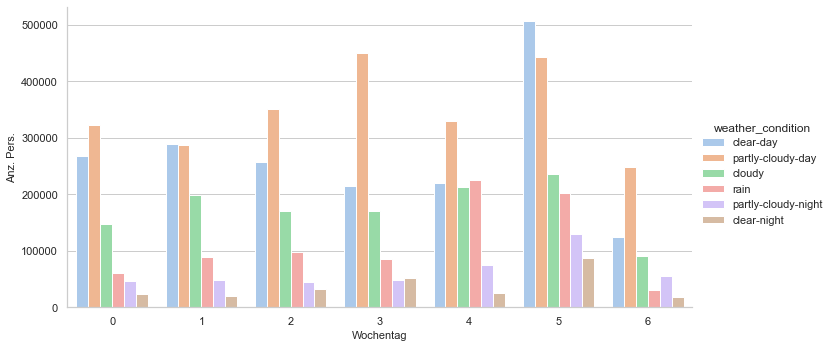

In [46]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="weekday"
            , y="sum_ltr_pedestrians_count"
            , hue="weather_condition"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.reset_index()
           )
myHist.set_xticklabels(rotation=0) 
myHist.set_xlabels('Wochentag', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Pers.', fontsize=11)


In [47]:
#data2betested.columns
#data2betested.dtypes
#data2betested.groupby(['unverified']).agg(test=('unverified', 'count'))

In [48]:
#myAgg = data2betested.loc["2022-01-01":date_today].query('unverified == True')\

myAggBar = data2betested.loc["2022-09-30 03":date_today]\
    .groupby(['location_id', 'location_name','ltr_label', 'rtl_label']) \
    .agg(sum_ltr_pedestrians_count=('ltr_pedestrians_count', 'sum')
         , sum_rtl_pedestrians_count=('rtl_pedestrians_count', 'sum')
         , sum_all_pedestrians_count=('pedestrians_count', 'sum')
        , avg_temp=('temperature', 'mean')
        , sum_adult_pedestrians_count=('adult_pedestrians_count', 'sum')
         , sum_child_pedestrians_count=('child_pedestrians_count', 'sum')         
        )\
    .sort_values('sum_ltr_pedestrians_count', ascending=False) 

myAggBar.reset_index().head(3)

location_id           location_name     ltr_label     rtl_label  sum_ltr_pedestrians_count  \
0          329  Bahnhofstrasse (Mitte)  Hauptbahnhof   Bürkliplatz                    1307154   
1          330    Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof                     708749   
2          331   Bahnhofstrasse (Nord)   Bürkliplatz  Hauptbahnhof                          0   

   sum_rtl_pedestrians_count  sum_all_pedestrians_count  avg_temp  sum_adult_pedestrians_count  \
0                    1210752                    2517906        10                      2478234   
1                     699812                    1408561        10                      1363128   
2                          0                          0        10                            0   

   sum_child_pedestrians_count  
0                        39672  
1                        45433  
2                            0

In [49]:
monthly_sums.reset_index().columns

Index(['timestamp', 'pedestrians_count', 'adult_pedestrians_count', 'child_pedestrians_count',
       'ltr_pedestrians_count', 'rtl_pedestrians_count', 'zone_1_pedestrians_count',
       'zone_2_pedestrians_count', 'zone_3_pedestrians_count'],
      dtype='object')

In [50]:
#aktuell nimmt die Zeitreihe nicht das laufende Jahr auf.

#days_tb = df_zeitreihe_tb.loc["2017-01-01 00:00":"2021-12-31 00:00"].dropna(axis=1).resample("D").median()
#months_tb =df_zeitreihe_tb[['air_temperature','water_temperature']].dropna(axis=1).loc["2017-01-01 00:00":"2021-12-31 00:00"].resample("M").median()


brush = alt.selection(type='interval', encodings=['x'])

upper = alt.Chart(weekly_sums[['zone_1_pedestrians_count', 'zone_2_pedestrians_count', 'zone_3_pedestrians_count']].loc["2021-12":"2022-11-21"].reset_index().melt("timestamp")).mark_area(interpolate="basis").encode(
    x = alt.X('timestamp:T', axis=None),
    y = alt.Y('value:Q', axis=None),
    color='variable'
).properties(width=1000, height=100).add_selection(brush)

lower = alt.Chart(daily_sums[['pedestrians_count','zone_1_pedestrians_count', 'zone_2_pedestrians_count', 'zone_3_pedestrians_count']].loc["2021-12":"2022-11-21"].reset_index().melt("timestamp")).mark_line(strokeWidth=1).encode(
    x = alt.X('timestamp:T', scale=alt.Scale(domain=brush)),
    y='value',
    color='variable',
).properties(width=1000, height=400)

upper & lower

alt.VConcatChart(...)

In [51]:
#data2betested.reset_index().columns

In [52]:
#.loc["2022-01-01":"2022-04-01"]
#.loc["2022-01-01":date_today]

myAggBar2 = data2betested.loc["2022-01-01":date_today].reset_index()\
    .groupby(['timestamp','location_id', 'location_name','ltr_label', 'rtl_label']) \
    .agg(sum_all_pedestrians_count=('pedestrians_count', 'sum')
         , sum_ltr_pedestrians_count=('ltr_pedestrians_count', 'sum')
         , sum_rtl_pedestrians_count=('rtl_pedestrians_count', 'sum')
        , avg_temp=('temperature', 'mean')
        , sum_adult_pedestrians_count=('adult_pedestrians_count', 'sum')
         , sum_child_pedestrians_count=('child_pedestrians_count', 'sum')         
        )\
    .sort_values('sum_all_pedestrians_count', ascending=False) 
myAggBar2.head()


sum_all_pedestrians_count  \
timestamp                 location_id location_name          ltr_label    rtl_label                                 
2022-08-13 13:00:00+00:00 330         Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof                      16481   
2022-06-18 13:00:00+00:00 329         Bahnhofstrasse (Mitte) Hauptbahnhof Bürkliplatz                       16417   
2022-08-13 14:00:00+00:00 330         Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof                      14997   
2022-08-13 13:00:00+00:00 329         Bahnhofstrasse (Mitte) Hauptbahnhof Bürkliplatz                       14002   
2022-08-13 12:00:00+00:00 330         Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof                      13853   

                                                                                        sum_ltr_pedestrians_count  \
timestamp                 location_id location_name          ltr_label    rtl_label                                 
2022-08-13 13:00:00+00:00 330         Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof                      14396   
2022-06-18 13:00:00+00:00 329         Bahnhofstrasse (Mitte) Hauptbahnhof Bürkliplatz                       13596   
2022-08-13 14:00:00+00:00 330         Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof                      12776   
2022-08-13 13:00:00+00:00 329         Bahnhofstrasse (Mitte) Hauptbahnhof Bürkliplatz                        2557   
2022-08-13 12:00:00+00:00 330         Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof                      12647   

                                                                                        sum_rtl_pedestrians_count  \
timestamp                 location_id location_name          ltr_label    rtl_label                                 
2022-08-13 13:00:00+00:00 330         Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof                       2085   
2022-06-18 13:00:00+00:00 329         Bahnhofstrasse (Mitte) Hauptbahnhof Bürkliplatz                        2821   
2022-08-13 14:00:00+00:00 330         Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof                       2221   
2022-08-13 13:00:00+00:00 329         Bahnhofstrasse (Mitte) Hauptbahnhof Bürkliplatz                       11445   
2022-08-13 12:00:00+00:00 330         Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof                       1206   

                                                                                        avg_temp  \
timestamp                 location_id location_name          ltr_label    rtl_label                
2022-08-13 13:00:00+00:00 330         Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof        28   
2022-06-18 13:00:00+00:00 329         Bahnhofstrasse (Mitte) Hauptbahnhof Bürkliplatz         32   
2022-08-13 14:00:00+00:00 330         Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof        29   
2022-08-13 13:00:00+00:00 329         Bahnhofstrasse (Mitte) Hauptbahnhof Bürkliplatz         28   
2022-08-13 12:00:00+00:00 330         Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof        27   

                                                                                        sum_adult_pedestrians_count  \
timestamp                 location_id location_name          ltr_label    rtl_label                                   
2022-08-13 13:00:00+00:00 330         Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof                        16397   
2022-06-18 13:00:00+00:00 329         Bahnhofstrasse (Mitte) Hauptbahnhof Bürkliplatz                         16296   
2022-08-13 14:00:00+00:00 330         Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof                        14922   
2022-08-13 13:00:00+00:00 329         Bahnhofstrasse (Mitte) Hauptbahnhof Bürkliplatz                         13947   
2022-08-13 12:00:00+00:00 330         Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof                        13788   

                                                                                        sum_c

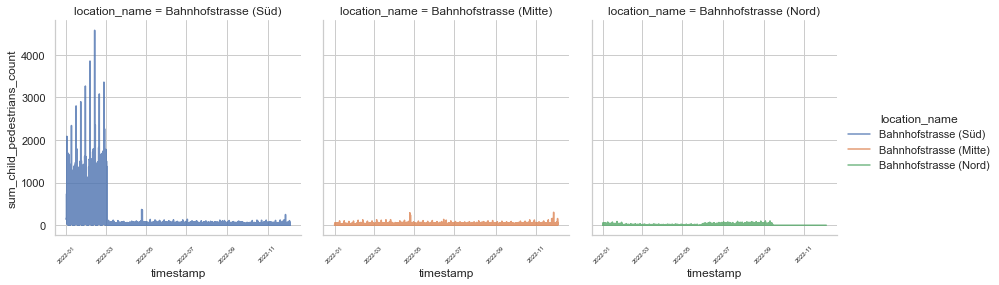

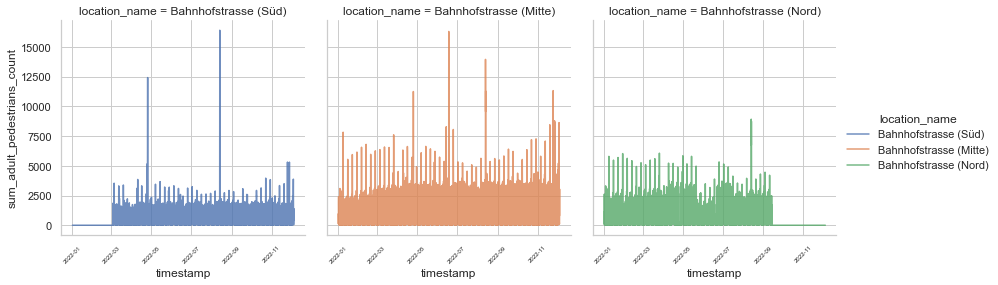

In [53]:
#g = sns.FacetGrid(myAggBar.reset_index(), col="QuarLang", hue="HerkunftLang", col_wrap=6, height=3,)
#g.map(sns.scatterplot, "AlterV05Sort", "sum_WBev", alpha=.8)
#g.add_legend()

g2 = sns.FacetGrid(myAggBar2.reset_index(), col="location_name", hue="location_name", col_wrap=3, height=4,)
g2.map(sns.lineplot, "timestamp","sum_child_pedestrians_count",alpha=.8)

g2.set_xticklabels(rotation=45, fontsize=6) 
g2.add_legend()

g3 = sns.FacetGrid(myAggBar2.reset_index(), col="location_name", hue="location_name", col_wrap=3, height=4,)
g3.map(sns.lineplot, "timestamp","sum_adult_pedestrians_count",alpha=.8)
#g2.map(sns.lineplot, "timestamp","sum_adult_pedestrians_count",alpha=.8)

g3.set_xticklabels(rotation=45, fontsize=6) 
g3.add_legend()

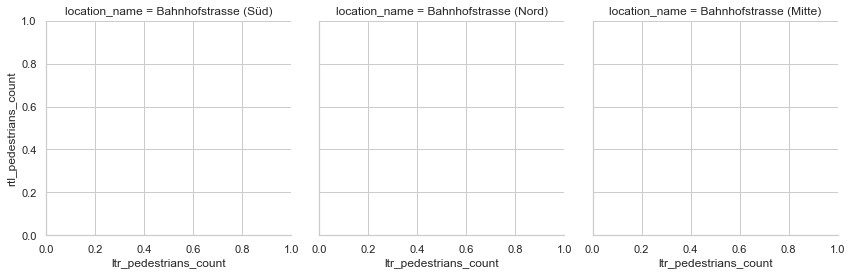

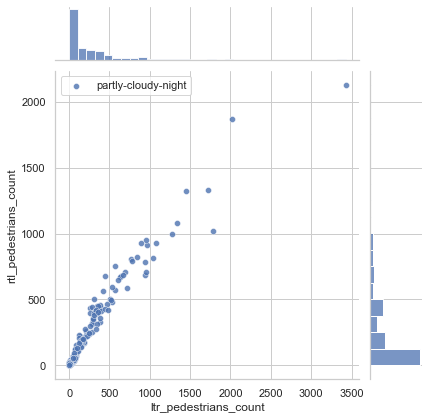

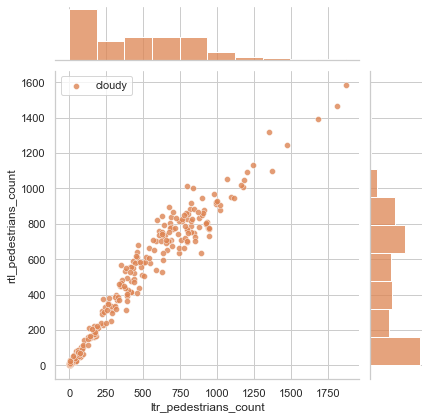

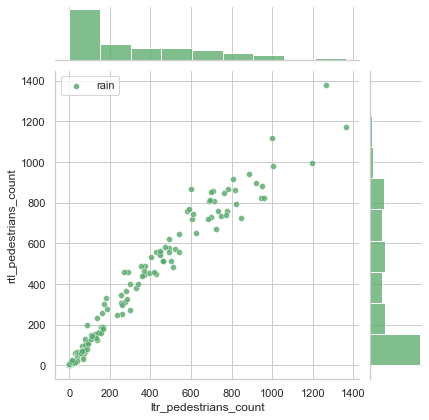

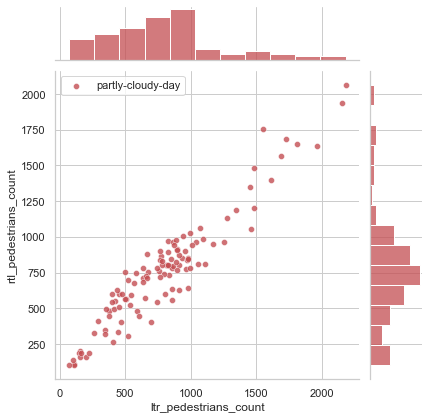

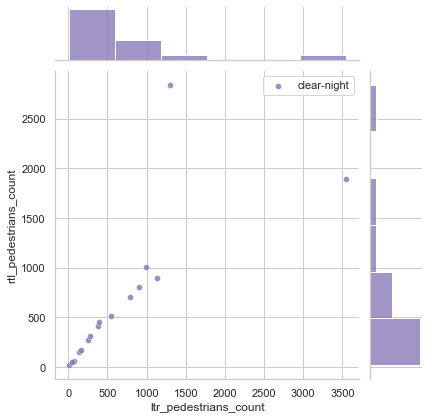

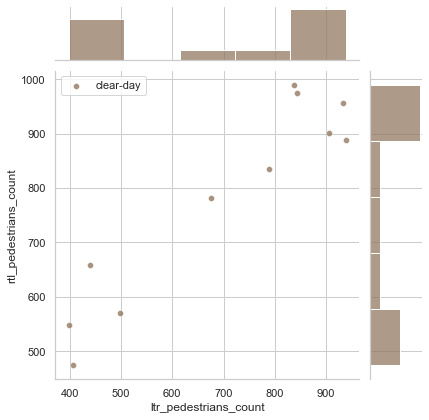

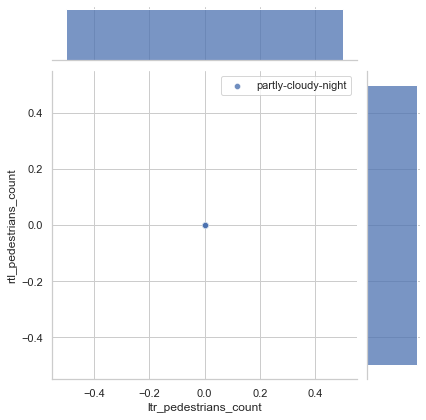

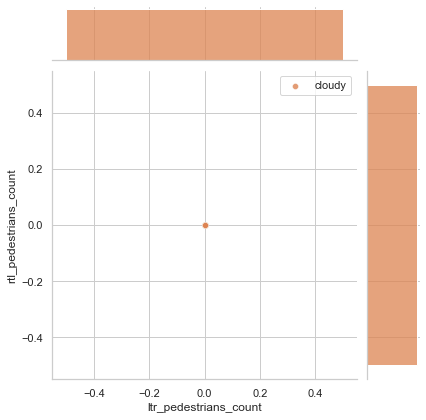

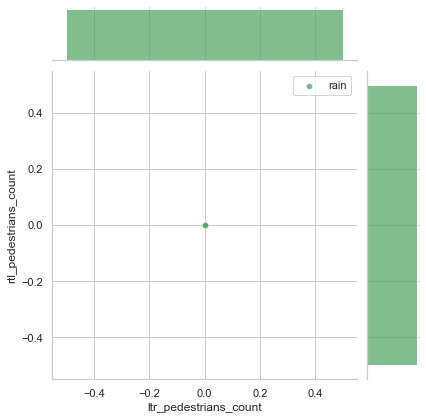

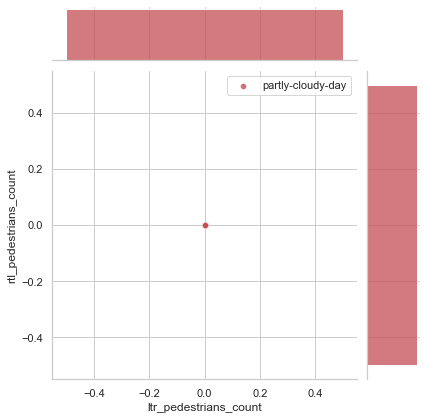

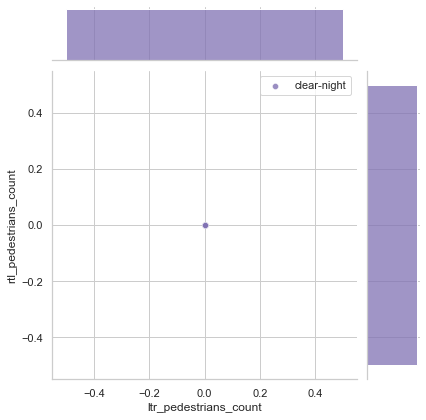

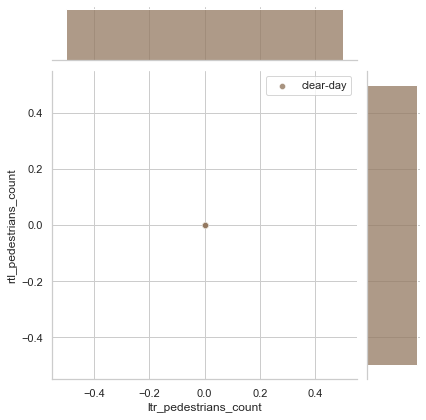

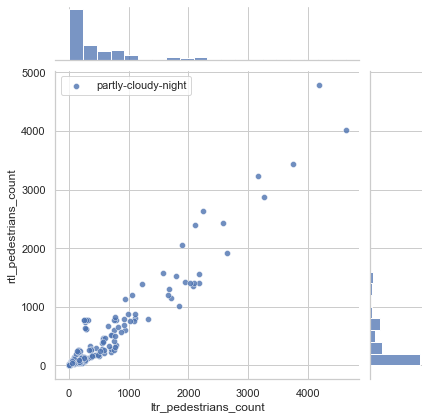

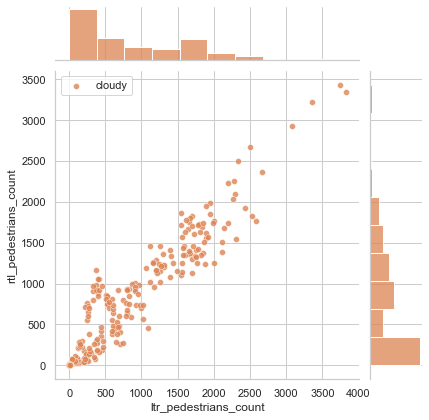

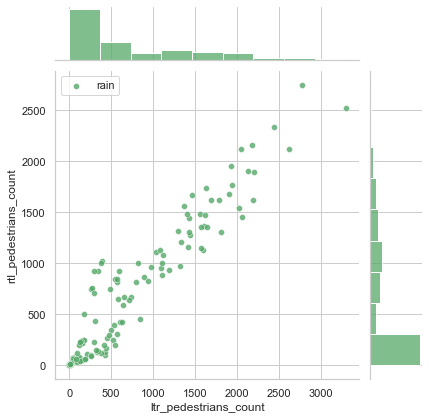

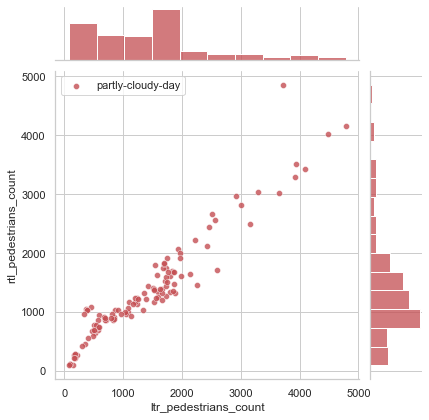

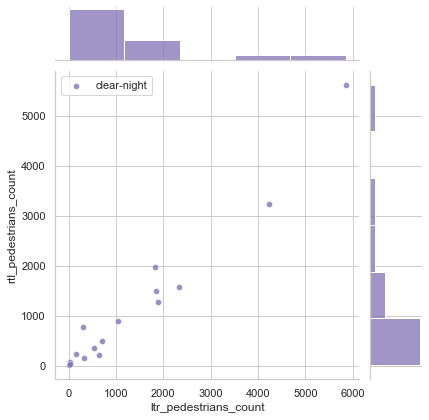

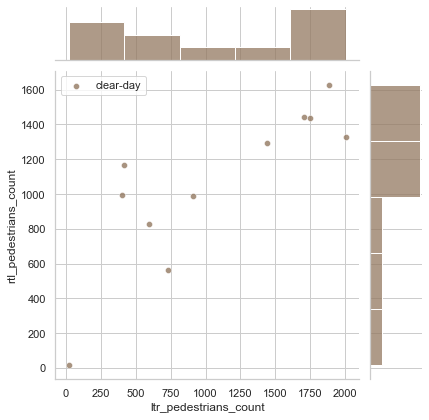

In [54]:
g4 = sns.FacetGrid(data2betested.loc["2022-11"].reset_index(),col="location_name",  hue="weather_condition", col_wrap=3, height=4,)
g4.map(sns.jointplot, "ltr_pedestrians_count", "rtl_pedestrians_count",alpha=.8)

#sns.jointplot(data=data2betested.loc["2022-07"].reset_index(), x="ltr_pedestrians_count", y="rtl_pedestrians_count", hue="weather_condition")
#sns.jointplot(data=data2betested.loc["2022-07"].reset_index(), x="ltr_pedestrians_count", y="rtl_pedestrians_count", hue="location_name")

### Daten in interaktiver Treemap zeigen
Dazu gibt es eine sehr nützliche Webseite https://plotly.com/python/treemaps/
Zu Farbskalen, siehe: https://plotly.com/python/builtin-colorscales/

#### Aktueller Bestand der WBev nach Quartier, Herkunft und Geschlecht

In [55]:
data2betested.columns


Index(['location_id', 'location_name', 'ltr_label', 'rtl_label', 'weather_condition',
       'temperature', 'pedestrians_count', 'unverified', 'ltr_pedestrians_count',
       'rtl_pedestrians_count', 'adult_pedestrians_count', 'child_pedestrians_count',
       'adult_ltr_pedestrians_count', 'adult_rtl_pedestrians_count', 'child_ltr_pedestrians_count',
       'child_rtl_pedestrians_count', 'zone_1_pedestrians_count', 'zone_1_ltr_pedestrians_count',
       'zone_1_rtl_pedestrians_count', 'zone_1_adult_pedestrians_count',
       'zone_1_child_pedestrians_count', 'zone_2_pedestrians_count',
       'zone_2_ltr_pedestrians_count', 'zone_2_rtl_pedestrians_count',
       'zone_2_adult_pedestrians_count', 'zone_2_child_pedestrians_count',
       'zone_3_pedestrians_count', 'zone_3_ltr_pedestrians_count', 'zone_3_rtl_pedestrians_count',
       'zone_3_adult_pedestrians_count', 'zone_3_child_pedestrians_count',
       'zone_99_pedestrians_count', 'zone_99_ltr_pedestrians_count',
       'zone_99_r

In [56]:
data2betested[['location_id', 'location_name', 'ltr_label', 'rtl_label', 'weather_condition','temperature', 'pedestrians_count', 'unverified', 'ltr_pedestrians_count'
               ,'rtl_pedestrians_count', 'adult_pedestrians_count', 'child_pedestrians_count']]\
.query('location_name=="Bahnhofstrasse (Nord)"').head(20)

location_id          location_name    ltr_label     rtl_label  \
timestamp                                                                                  
2022-12-04 12:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2022-12-04 11:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2022-12-04 10:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2022-12-04 09:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2022-12-04 08:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2022-12-04 07:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2022-12-04 06:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2022-12-04 05:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2022-12-04 04:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2022-12-04 03:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2022-12-04 02:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2022-12-04 01:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2022-12-04 00:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2022-12-03 23:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2022-12-03 22:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2022-12-03 21:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2022-12-03 20:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2022-12-03 19:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2022-12-03 18:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2022-12-03 17:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   

                             weather_condition  temperature  pedestrians_count  unverified  \
timestamp                                                                                    
2022-12-04 12:00:00+00:00               cloudy            4                  0        True   
2022-12-04 11:00:00+00:00               cloudy            3                  0        True   
2022-12-04 10:00:00+00:00               cloudy            2                  0        True   
2022-12-04 09:00:00+00:00               cloudy            1                  0        True   
2022-12-04 08:00:00+00:00               cloudy            0                  0        True   
2022-12-04 07:00:00+00:00  partly-cloudy-night           -1                  0        True   
2022-12-04 06:00:00+00:00  partly-cloudy-night           -1                  0        True   
2022-12-04 05:00:00+00:00               cloudy           -0                  0        True   
2022-12-04 04:00:00+00:00               cloudy           -0                  0        True   
2022-12-04 03:00:00+00:00               cloudy           -0                  0        True   
2022-12-04 02:00:00+00:00               cloudy           -0                  0        True   
2022-12-04 01:00:00+00:00               cloudy            0                  0        True   
2022-12-04 00:00:00+00:00               cloudy           -0                  0        True   
2022-12-03 23:00:00+00:00               cloudy           -0                  0        True   
2022-12-03 22:00:00+00:00               cloudy           -0                  0       False   
2022-12-03 21:00:00+00:00               cloudy            0                  0       False   
2022-12-03 20:00:00+00:00               cloudy            0                  0       False   
2022-12-03 19:00:00+00:00               cloudy            1                  0       False   
2022-12-03 18:00:00+00:00               cloudy            1                  0       False   
2022-12-03 17:00:00+00:00  p

In [57]:
myTreemapAgg = data2betested \
    .groupby(['year', 'month','day', 'location_name']) \
    .agg(sum_pedestrians_count=('pedestrians_count', 'sum')) \
    .sort_values('sum_pedestrians_count', ascending=True) 

myTreemapAgg.reset_index().head(6)

year  month  day          location_name  sum_pedestrians_count
0  2022     10   23  Bahnhofstrasse (Nord)                      0
1  2022     10    7  Bahnhofstrasse (Nord)                      0
2  2022     10    8  Bahnhofstrasse (Nord)                      0
3  2022     10    9  Bahnhofstrasse (Nord)                      0
4  2022     10   10  Bahnhofstrasse (Nord)                      0
5  2022     10   11  Bahnhofstrasse (Nord)                      0

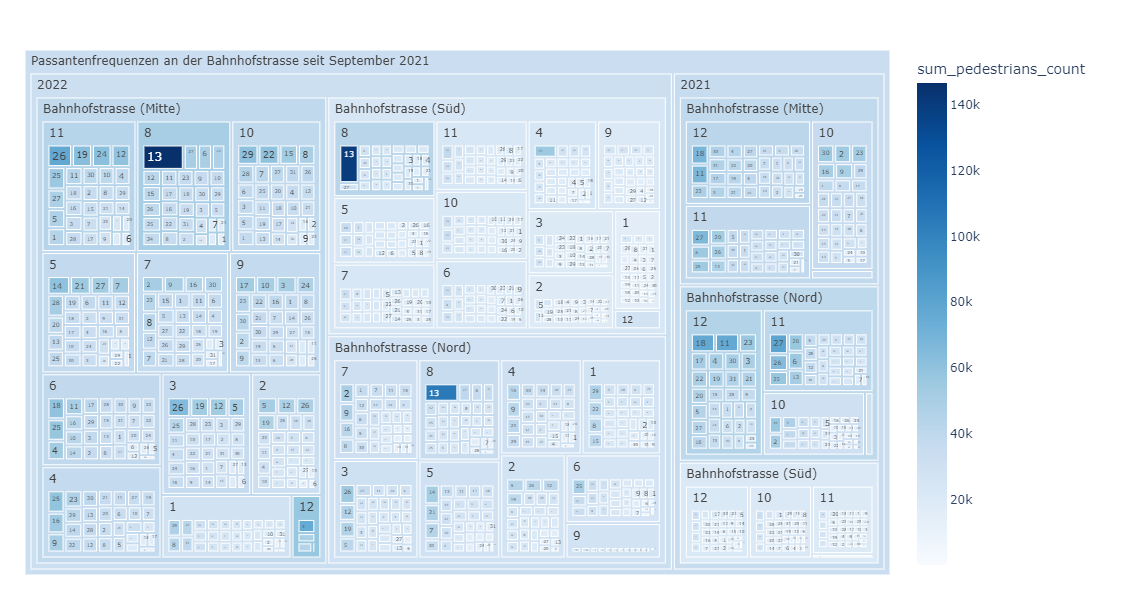

In [58]:
myTitle = "Passantenfrequenzen an der Bahnhofstrasse seit September 2021"

fig = px.treemap(myTreemapAgg.query('sum_pedestrians_count>0').reset_index(), path=[px.Constant(myTitle), 'year','location_name', 'month','day']
                 , values='sum_pedestrians_count'
                 , color='sum_pedestrians_count'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='Blues'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=600
                 ,width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

---------

## --- Plausi stopped here

#### Aktueller Bestand der WBev nach Quartier und Herkunft

In [ ]:
#data2betested.columns

In [ ]:
myTreemapAgg = data2betested.loc['2021']  \
    .groupby(['StichtagDatJahr', 'QuarLang', 'HerkunftLang']) \
    .agg(sum_WBev=('AnzBestWir', 'sum')) \
    .sort_values('sum_WBev', ascending=True) 

myTreemapAgg.reset_index().head(3)

In [ ]:
myTitle = "WBev nach Quartier und Herkunft, 2021"

fig = px.treemap(myTreemapAgg.reset_index(), path=[px.Constant(myTitle), 'StichtagDatJahr', 'QuarLang', 'HerkunftLang']
                 , values='sum_WBev'
                 , color='HerkunftLang'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'Ausländer/in':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }         
                 , color_discrete_map={'(?)':'lightgrey','Schweizer/in':'gold', 'SP':'#FF3030' }               
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='blues'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])   
                 ,height=400
                 ,width=1100
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [ ]:
#data2betested.dtypes

## ---------------------- hier Plausi beendet

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=115&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**

---------------------------------------------------------------------------

### Test: Choroplethenkarte
Importiere die Geodaten als GeoJSON

#### Stadtkreise

In [ ]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_kreise = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Stadtkreise?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_stadtkreise_v"
adm_stadtkreise_v = gpd.read_file(geojson_url_kreise)

adm_stadtkreise_v.head(1)


#### Statistische Zonen

In [ ]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_statzonen = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Zonen?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statzonen_map"
adm_statzonen_map = gpd.read_file(geojson_url_statzonen)

adm_statzonen_map.head(2)


#### Statistische Quartiere

In [ ]:
geojson_url_quartiere = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Quartiere?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statistische_quartiere_map"
df_adm_statistische_quartiere_map = gpd.read_file(geojson_url_quartiere)

df_adm_statistische_quartiere_map.head(2)


### Teste LeafMap

Mehr Infos: https://leafmap.org/leafmap/

In [ ]:
m = leafmap.Map()

#m.add_geojson(geojson_url_kreise, layer_name="adm_stadtkreise_v", fill_colors=['red', 'yellow', 'green', 'orange'], info_mode=True)
m.add_gdf(df_adm_statistische_quartiere_map, layer_name='adm_statistische_quartiere_map', style={}, hover_style={}, style_callback=None, fill_colors=['black'], info_mode='on_hover', zoom_to_layer=True)
m.add_gdf(adm_stadtkreise_v, layer_name='adm_stadtkreise_v', style={}, hover_style={}, style_callback=None, fill_colors=['none'], info_mode='on_hover', zoom_to_layer=False)

m.add_legend(title='Legende', legend_dict=None, labels=None, colors=None, position='bottomright', builtin_legend=None, layer_name='adm_statistische_quartiere_map')
m

### Joins
Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

In [ ]:
#data2betested.dtypes
data2betested.head()

In [ ]:
myAgg = data2betested.loc["2020"]  \
    .copy() \
    .groupby(['QuarLang', 'QuarCd']) \
    .agg(sum_AnzBestWir=('AnzBestWir', 'sum')) \
    .assign() \
    .sort_values('QuarCd', ascending=False) 

#myAgg.reset_index()


In [ ]:
# Rename attribute stznr to StatZoneSort, so the IDs have the same name
gdf_adm_statistische_quartiere_map = df_adm_statistische_quartiere_map[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'QuarCd'})
gdf_adm_statistische_quartiere_map.head(1)

#### Leftjoin 
Matche die statistischen Daten mit den Geodaten

In [ ]:
# Merge with `merge` method on shared variable (stznr und StatZoneSort):
gdf_adm_statistische_quartiere_map_joined = gdf_adm_statistische_quartiere_map.merge(myAgg, on='QuarCd', how="left") #'right', 'inner', 'left'
gdf_adm_statistische_quartiere_map_joined.head(2)


In [ ]:
#does all match?
gdf_adm_statistische_quartiere_map_joined.isnull().sum()

In [ ]:
# Plot by StatQuartiere
# Weitere Schemes: scheme='quantiles', scheme='fisherjenks', scheme='natural_breaks',

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_AnzBestWir', cmap='viridis', scheme='natural_breaks', legend=True )
gdf_adm_statistische_quartiere_map_joined.plot(column='sum_AnzBestWir', cmap='viridis', scheme='fisherjenks', legend=True )

#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

#
#Neuere Gallerie: https://matplotlib.org/stable/gallery/index.html

In [ ]:
fig, ax = plt.subplots(1, 1)

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_AnzBestWir', ax=ax, legend=True, legend_kwds={'label': "Anzahl WBev 2020",'orientation': "horizontal"})
#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_AnzBestWir', ax=ax, legend=False, legend_kwds={'label': "Anzahl WBev 2020",'orientation': "horizontal"})

#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='viridis', scheme='natural_breaks', legend=True , ax=ax, legend_kwds={'label': "Anzahl Personen",'orientation': "horizontal"})

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=115&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**